In [1]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from classes import QCA
from helpers import plot_seq_attr
import random
import serpyco

import bitsandbytes as bnb
from captum.attr import LayerIntegratedGradients, LLMGradientAttribution, TextTokenInput

import spacy
nlp = spacy.load('en_core_web_sm')

import warnings
# Ignore warnings due to transformers library
warnings.filterwarnings("ignore", ".*past_key_values.*")
warnings.filterwarnings("ignore", ".*Skipping this token.*")

torch.manual_seed(23)

In [2]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",  # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [3]:
bnb_config = create_bnb_config()
olmo, tokenizer = load_model("allenai/OLMo-1B-hf", bnb_config)

serializer = serpyco.Serializer(QCA)

In [13]:
FILENAME = 'data/validation-spacy.jsonl'

In [14]:
qcas = [serializer.load(json.loads(x)) for x in open(FILENAME).read().split('\n')[:-1]]
random.Random(42).shuffle(qcas)
n_steps = 10

In [15]:
#change & change_q from Sagniks code
change = {'first': 'last', 
          'earlier': 'later', 
          'younger': 'older', 
          'later': 'earlier', 
          'older': 'younger',
          'more recently': 'earlier'}

def make_prompt(C,Q):
    prompt = f"""Use the context to answer the question. Context: {C} Question: {Q} Answer: """
    return prompt

def change_q(question):
    for k, v in change.items():
        if k in question:
            return question.replace(k, v)
        
def make_reversed_qs(Q, A):
    doc = nlp(Q)
    ents = set()
    for ent in doc.ents:
        #print(ent.text, ent.start_char, ent.end_char, ent.label_) 
        if ent.text in Q and ent.label_ in ['PERSON','NORP','FAC','ORG','GPE', 'LOC', 'PRODUCT', 'EVENT','WORK_OF_ART','LAW','LANGUAGE'] :
            ents.add(ent.text) 
    
    #print(ents, Q, end = ' ')
    ents = list(ents)
    if len(ents)==2:
        if ents[0] in ents[1] or ents[1] in ents[0]:
            return None, None
        elif ents[0] in A:
            #print('accepted')
            A2 = ents[1]
        elif ents[1] in A:
            #print('accepted')
            A2 = ents[0]
        else:
            #print('failed')
            return None, None
        Q2 = change_q(Q)
        return Q2, A2

    else:
        #print('failed')
        return None,None
c = 0
k = 0
prompts = {}
for data in qcas[:]:    
    Q, C, A = data.question.text, data.context.text, data.answer_texts_orig[0]
    Q2, A2 = make_reversed_qs(Q, A)

    if Q2 != None:
        c+=1
        # print(Q, A)
        # print(Q2, A2)
        prompt = make_prompt(C, Q)
        prompt_2 = make_prompt(C, Q2)
        prompts[data.id] = {'prompt_o': prompt, 'gold_o': A, 
                            'prompt_s': prompt_2, 'gold_s': A2}

    else:
        k+=1

print(f'{c}, {k}, {c/(c+k):.2%}')

1236, 1734, 41.62%


In [18]:
import json

with open('val_comp.json', 'w') as fp:
    fp.write(json.dumps(prompts))

In [15]:
data = prompts['2wiki-acfbbcd508f311ebbdaaac1f6bf848b6']
prompt = data['prompt_o']
A = ' ' + data['gold_o']

prompt_2 = data['prompt_s']
A2= ' ' + data['gold_s']

In [16]:
lig = LayerIntegratedGradients(olmo, olmo.model.embed_tokens)

llm_attr = LLMGradientAttribution(lig, tokenizer)

In [17]:
inp = TextTokenInput(
    prompt, 
    tokenizer)

attr_res = llm_attr.attribute(inp, target=A, n_steps=n_steps)

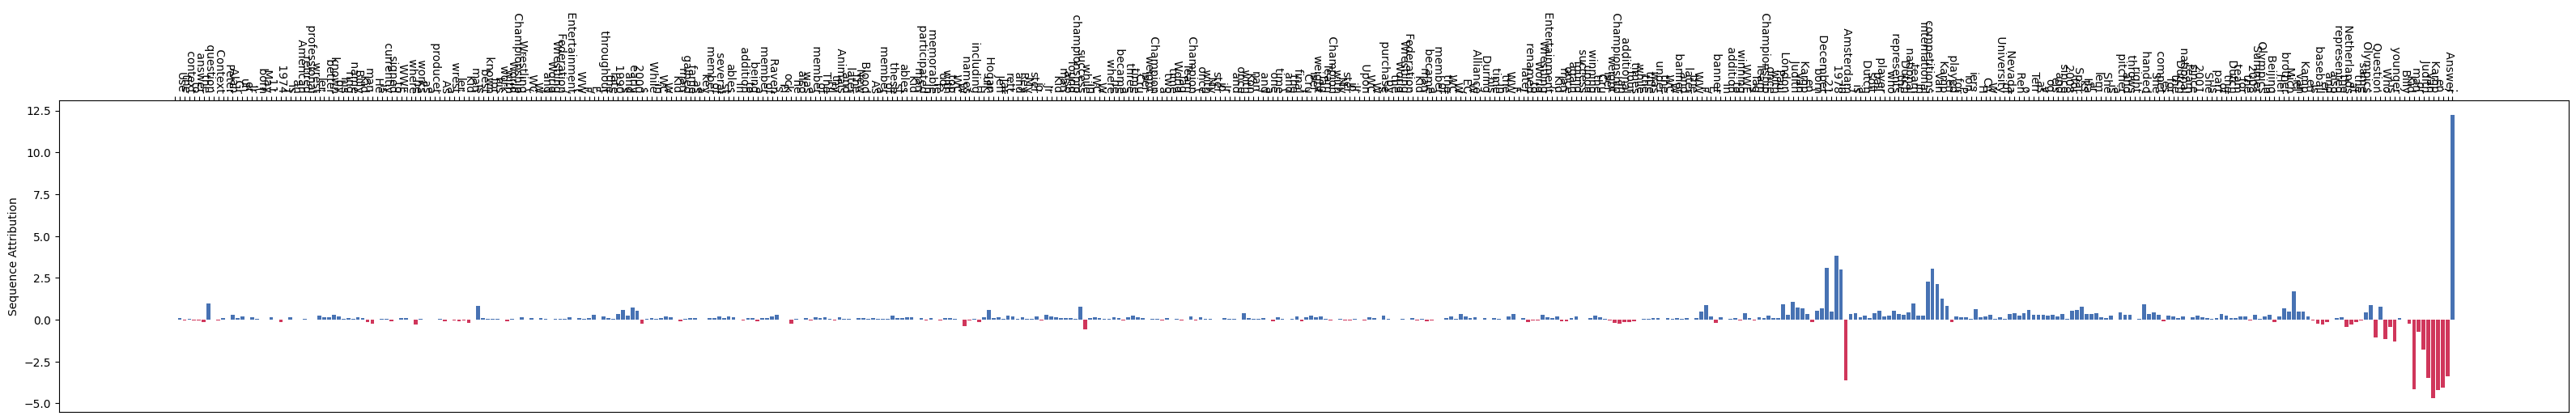

In [18]:
plot_seq_attr(attr_res, show=True, figsize=(40,5), filename=f'img/{A}_prompt_{n_steps}')

In [19]:
attr_res.output_tokens

['ĠVan', 'ĠKamp', 'en']

In [20]:
inp = TextTokenInput(
    prompt_2, 
    tokenizer)

attr_res_p = llm_attr.attribute(inp, target=A2, n_steps=n_steps)

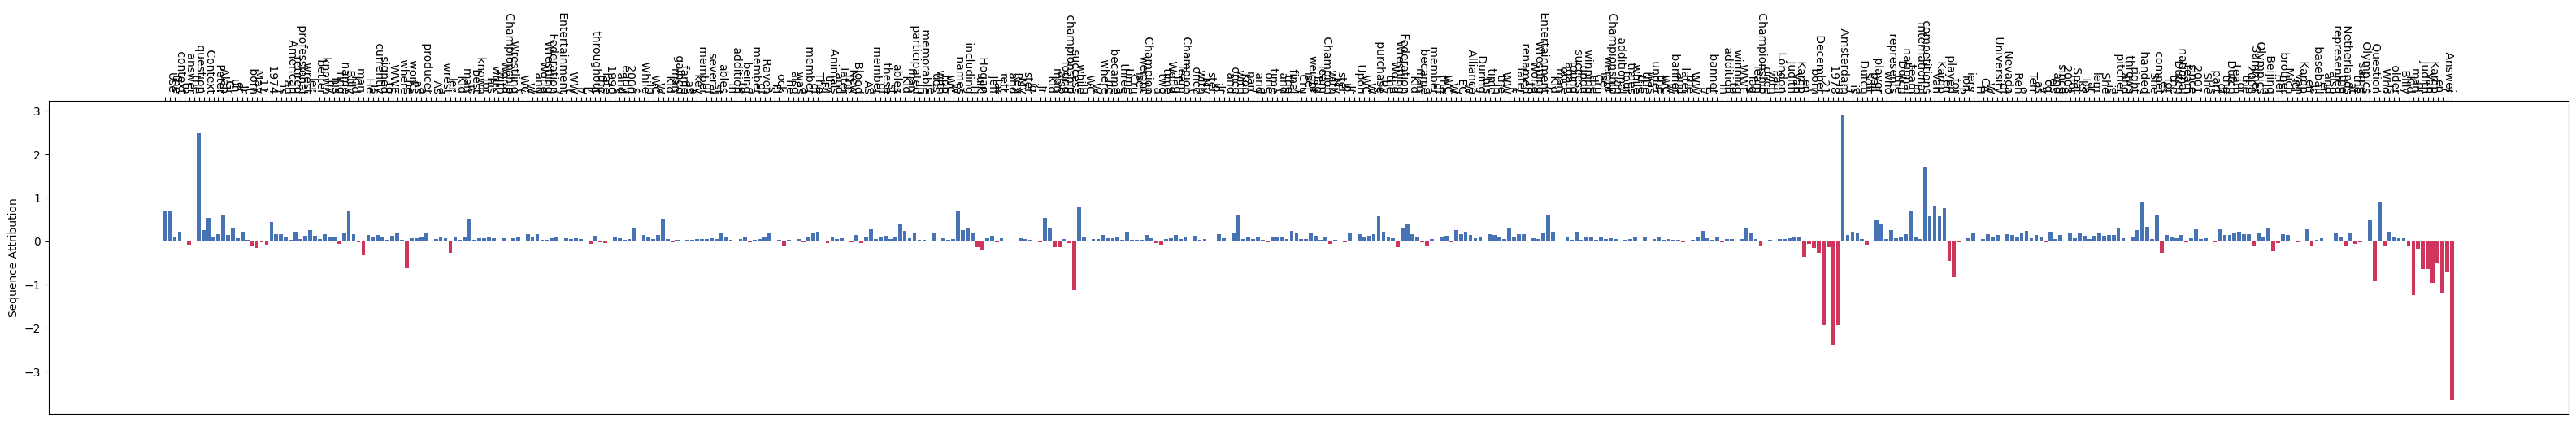

In [21]:
plot_seq_attr(attr_res_p, show=True, figsize=(40,5), filename=f'img/{A2}_prompt_{n_steps}')

In [22]:
attr_res_p.output_tokens

['ĠKid', 'man']